Import all the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.math import confusion_matrix
import numpy as np
import os


Data generators and Data augmentation

In [2]:
train_data_dir = r'D:\Documentos\Semestre8\Aplicaciones avanzadas\AI\Proyecto\AImodel\images3\train'
test_data_dir = r'D:\Documentos\Semestre8\Aplicaciones avanzadas\AI\Proyecto\AImodel\images3\test'
validation_data_dir = r'D:\Documentos\Semestre8\Aplicaciones avanzadas\AI\Proyecto\AImodel\images3\validation'

total_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])

train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                 rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 fill_mode='nearest',
                                 validation_split=0.1) 

datagen = ImageDataGenerator(1./255)   

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical', 
    shuffle=True)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=120,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=40,
    class_mode='categorical',
    shuffle=True)


Found 1869 images belonging to 5 classes.
Found 127 images belonging to 5 classes.
Found 124 images belonging to 5 classes.


Callback in case the model is not improving 

In [3]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

Transfer Learning Model 1

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

flatten_layer = layers.Flatten()(base_model.output)
dense_layer1 = layers.Dense(128, activation='relu')(flatten_layer)
dropout_layer = layers.Dropout(0.6)(dense_layer1)
dense_layer2 = layers.Dense(5, activation='softmax')(dropout_layer)

transfer_model = models.Model(inputs=base_model.input, outputs=dense_layer2)

transfer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [12]:
transfer_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [13]:
history1 = transfer_model.fit(train_generator, 
				steps_per_epoch =50,  
				epochs =100,
                validation_data=validation_generator,
            	validation_steps=3,
                callbacks=[early_stopping]
				)

Epoch 1/100
50/50 [==============================] - 63s 1s/step - loss: 15.5662 - accuracy: 0.3175 - val_loss: 3.1700 - val_accuracy: 0.4167
Epoch 2/100
50/50 [==============================] - 60s 1s/step - loss: 2.9387 - accuracy: 0.4325 - val_loss: 1.8615 - val_accuracy: 0.4250
Epoch 3/100
50/50 [==============================] - 59s 1s/step - loss: 2.0135 - accuracy: 0.3713 - val_loss: 1.5111 - val_accuracy: 0.3583
Epoch 4/100
50/50 [==============================] - 59s 1s/step - loss: 1.5026 - accuracy: 0.4479 - val_loss: 1.3859 - val_accuracy: 0.4750
Epoch 5/100
50/50 [==============================] - 59s 1s/step - loss: 1.4461 - accuracy: 0.4025 - val_loss: 1.4050 - val_accuracy: 0.4500
Epoch 6/100
50/50 [==============================] - 59s 1s/step - loss: 1.4292 - accuracy: 0.4350 - val_loss: 1.3613 - val_accuracy: 0.4583
Epoch 7/100
50/50 [==============================] - 59s 1s/step - loss: 1.2798 - accuracy: 0.4638 - val_loss: 1.3516 - val_accuracy: 0.5000
Epoch 8/100


In [14]:
test_loss, test_acc = transfer_model.evaluate(test_generator, steps = 1)
print('\ntest acc :\n', test_acc)

1/1 [==============================] - 9s 9s/step - loss: 0.7132 - accuracy: 0.7000

test acc :
 0.699999988079071


In [15]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]

class_names = list(train_generator.class_indices.keys())

predictions = transfer_model.predict(test_imgs)
classes_x = np.argmax(predictions,axis=1)
classex_y = np.argmax(test_labels,axis=1)

mat = confusion_matrix(classes_x, classex_y)
print(mat) 
print(classification_report(classes_x, classex_y, target_names=class_names))

4/4 [==============================] - 8s 2s/step
tf.Tensor(
[[27  3  0  3  0]
 [ 3 13  0  1  0]
 [ 0  0  9  2  1]
 [ 1  1  3 15  5]
 [ 2  2  4  6 19]], shape=(5, 5), dtype=int32)
                  precision    recall  f1-score   support

ECONOMIC_VEHICLE       0.82      0.82      0.82        33
      FAMILY_CAR       0.68      0.76      0.72        17
      LUXURY_CAR       0.56      0.75      0.64        12
      SPORTS_CAR       0.56      0.60      0.58        25
       SUPER_CAR       0.76      0.58      0.66        33

        accuracy                           0.69       120
       macro avg       0.68      0.70      0.68       120
    weighted avg       0.70      0.69      0.69       120



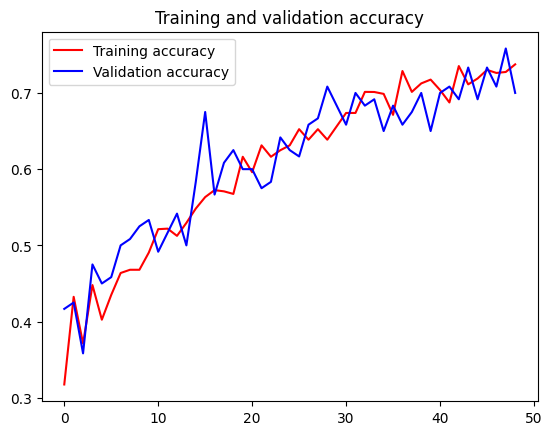

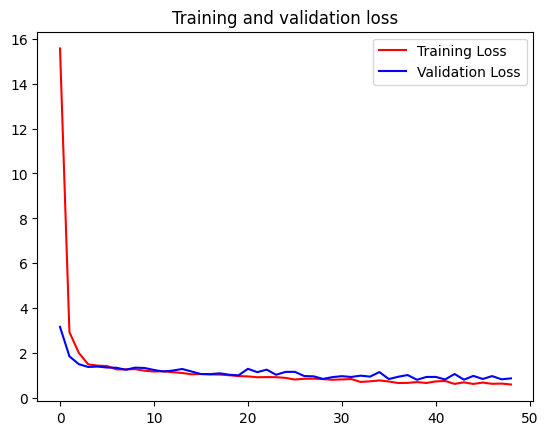

In [16]:
# Plot the chart for accuracy and loss on both training and validation
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Transfer Model with adjustments

In [35]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

flatten_layer = layers.Flatten()(base_model.output)
dense_layer1 = layers.Dense(64, activation='relu')(flatten_layer)
dropout_layer = layers.Dropout(0.5)(dense_layer1)
dense_layer2 = layers.Dense(5, activation='softmax')(dropout_layer)

transfer_model2 = models.Model(inputs=base_model.input, outputs=dense_layer2)

transfer_model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [37]:
transfer_model2.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [38]:
history2 = transfer_model2.fit(train_generator, 
				steps_per_epoch =50,  
				epochs =100,
                validation_data=validation_generator,
            	validation_steps=3
				)

Epoch 1/100


C:\Users\joako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


50/50 [==============================] - 60s 1s/step - loss: 11.1717 - accuracy: 0.2625 - val_loss: 1.8949 - val_accuracy: 0.4500
Epoch 2/100
50/50 [==============================] - 58s 1s/step - loss: 1.8495 - accuracy: 0.3689 - val_loss: 1.6094 - val_accuracy: 0.3917
Epoch 3/100
50/50 [==============================] - 58s 1s/step - loss: 1.5051 - accuracy: 0.3613 - val_loss: 1.5018 - val_accuracy: 0.4500
Epoch 4/100
50/50 [==============================] - 58s 1s/step - loss: 1.4963 - accuracy: 0.4212 - val_loss: 1.4879 - val_accuracy: 0.4250
Epoch 5/100
50/50 [==============================] - 58s 1s/step - loss: 1.4035 - accuracy: 0.4442 - val_loss: 1.3759 - val_accuracy: 0.4417
Epoch 6/100
50/50 [==============================] - 59s 1s/step - loss: 1.3387 - accuracy: 0.4938 - val_loss: 1.2899 - val_accuracy: 0.5583
Epoch 7/100
50/50 [==============================] - 58s 1s/step - loss: 1.2409 - accuracy: 0.4863 - val_loss: 1.3405 - val_accuracy: 0.5500
Epoch 8/100
50/50 [=====

In [39]:
test_loss, test_acc = transfer_model2.evaluate(test_generator, steps = 1)
print('\ntest acc :\n', test_acc)

1/1 [==============================] - 10s 10s/step - loss: 0.7476 - accuracy: 0.7795

test acc :
 0.7795275449752808


In [40]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]

class_names = list(train_generator.class_indices.keys())

predictions = transfer_model2.predict(test_imgs)
classes_x = np.argmax(predictions,axis=1)
classex_y = np.argmax(test_labels,axis=1)

mat = confusion_matrix(classes_x, classex_y)
print(mat) 
print(classification_report(classes_x, classex_y, target_names=class_names))

4/4 [==============================] - 8s 2s/step
tf.Tensor(
[[31  3  0  1  0]
 [ 0 14  1  3  0]
 [ 0  1 11  1  0]
 [ 6  1  5 21  4]
 [ 0  0  1  1 22]], shape=(5, 5), dtype=int32)
                  precision    recall  f1-score   support

ECONOMIC_VEHICLE       0.84      0.89      0.86        35
      FAMILY_CAR       0.74      0.78      0.76        18
      LUXURY_CAR       0.61      0.85      0.71        13
      SPORTS_CAR       0.78      0.57      0.66        37
       SUPER_CAR       0.85      0.92      0.88        24

        accuracy                           0.78       127
       macro avg       0.76      0.80      0.77       127
    weighted avg       0.78      0.78      0.77       127



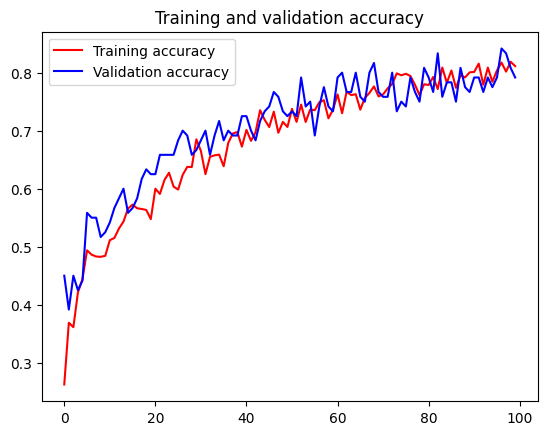

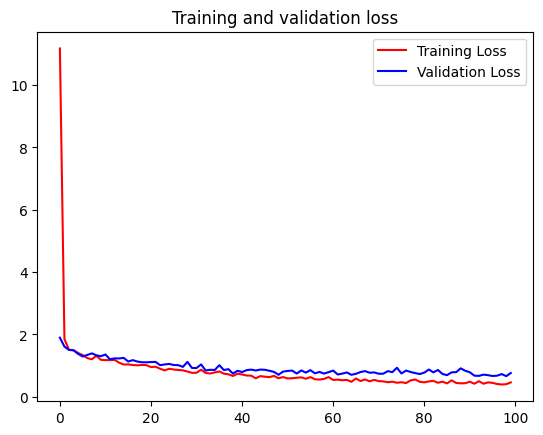

In [54]:
# Plot the chart for accuracy and loss on both training and validation
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Sequential model 

In [34]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(5, activation='softmax'))
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 128)     

In [35]:
model3.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [36]:
history3 = model3.fit(train_generator, 
				steps_per_epoch =50,  
				epochs =100,
                validation_data=validation_generator,
            	validation_steps=3,
                callbacks=[early_stopping]
				)

Epoch 1/100
50/50 [==============================] - 28s 536ms/step - loss: 9.3304 - accuracy: 0.2188 - val_loss: 1.6025 - val_accuracy: 0.2833
Epoch 2/100
50/50 [==============================] - 26s 521ms/step - loss: 1.7561 - accuracy: 0.2396 - val_loss: 1.6028 - val_accuracy: 0.2167
Epoch 3/100
50/50 [==============================] - 26s 522ms/step - loss: 1.6282 - accuracy: 0.2250 - val_loss: 1.6042 - val_accuracy: 0.2500
Epoch 4/100
50/50 [==============================] - 26s 521ms/step - loss: 1.6276 - accuracy: 0.2422 - val_loss: 1.6048 - val_accuracy: 0.2333
Epoch 5/100
50/50 [==============================] - 26s 522ms/step - loss: 1.5975 - accuracy: 0.2537 - val_loss: 1.5898 - val_accuracy: 0.2583
Epoch 6/100
50/50 [==============================] - 26s 524ms/step - loss: 1.6013 - accuracy: 0.3088 - val_loss: 1.5799 - val_accuracy: 0.2667
Epoch 7/100
50/50 [==============================] - 26s 520ms/step - loss: 1.5592 - accuracy: 0.2887 - val_loss: 1.5213 - val_accuracy:

In [37]:
test_loss, test_acc = model3.evaluate(test_generator, steps = 1)
print('\ntest acc :\n', test_acc)

1/1 [==============================] - 1s 1s/step - loss: 1.2381 - accuracy: 0.4917

test acc :
 0.49166667461395264


In [38]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]

class_names = list(train_generator.class_indices.keys())

predictions = model3.predict(test_imgs)
classes_x = np.argmax(predictions,axis=1)
classex_y = np.argmax(test_labels,axis=1)

mat = confusion_matrix(classes_x, classex_y)
print(mat) 
print(classification_report(classes_x, classex_y, target_names=class_names))

4/4 [==============================] - 1s 173ms/step
tf.Tensor(
[[22 12  0  6  0]
 [ 3  1  0  0  0]
 [ 1  2  8  4  6]
 [ 8  3  8 15  4]
 [ 2  0  1  0 14]], shape=(5, 5), dtype=int32)
                  precision    recall  f1-score   support

ECONOMIC_VEHICLE       0.61      0.55      0.58        40
      FAMILY_CAR       0.06      0.25      0.09         4
      LUXURY_CAR       0.47      0.38      0.42        21
      SPORTS_CAR       0.60      0.39      0.48        38
       SUPER_CAR       0.58      0.82      0.68        17

        accuracy                           0.50       120
       macro avg       0.46      0.48      0.45       120
    weighted avg       0.56      0.50      0.52       120



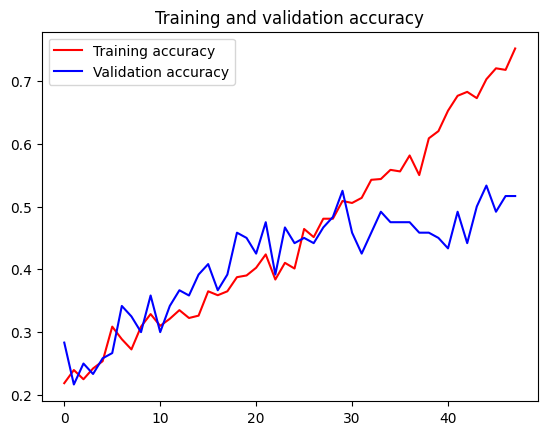

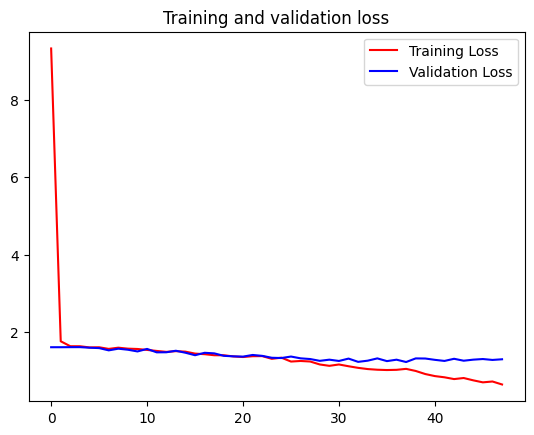

In [39]:
# Plot the chart for accuracy and loss on both training and validation
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()